## A Rough Skeleton of Working Draft
---------------------------------------------------------------------------------------------------------


### Table of Contents:
1. Sypnosis
    - Research Question
    - Summary
<p></p>
2. Our Data Set 
    - Packages Used
    - Loading and Cleansing
    
---------------------------------------------------------------------------------------------------------

### 1.) Sypnosis: 

##### Research Question:
How can an author increase engagement from users on Facebook and can we predict the success of a post using insights from an author's page?


##### Overview:
<p></p>
The market utility of social media platforms such as Facebook, which are able to generate mass revenues for cosmetic brands, has been an established and exploited advertising strategy in the digital age (Moro et. al, 2016). The goal of this project is to take a predictive analytical approach to determine which type of Facebook post (i.e., photo, video, status, or link) will engage the most internet-user engagement, determined through variables such as likes, post consumptions, and post total reach. The dataset which will be used for this analysis was acquired through an experimental data mining technique which included scraping data from the Facebook page of an internationally renowned cosmetics company on posts made between January 1st and December 31st (Moro et. al., 2016).
<p></p>
Our data includes posts from both paid and non-paid marketing campaigns. Social media algorithms that adjust prioritizations between paid and non-paid posts can heavily factor into our metrics received and should be considered in this analysis. In order to explore the relationship between post type and our defined success metric, we can further isolate our data into paid and unpaid categories.
<p></p>
With our acquired data, we must first compartmentalize into training and testing sets before performing an exploratory data analysis on our dataset. We chose to approach our training data by creating a 80:20 ratio between testing and training data meaning 80% of our total data will be labeled as the “general training set” and the remainder as our “test set”. The general training set will be further partitioned into a “validation set” and “training set” in order to reduce bias within our model data and testing data. Now that we’ve labeled our training data, we can further explore the summary statistics within each set. 
<p></p>
For the methodology, we will use the variables of the continuous numerical variables of total reaches (Lifetime_Post_Total_Reach) and of the number of total impressions (Lifetime_Post_Total_Impressions), and the categorical variable of Facebook post (Type). First, we will look at the relationship between these variables in a scatter plot graph that will help us to formulate our hypothesis. Then, as we are trying to predict the type of post that will be the most successful, we will use a K-nearest neighbour classification analysis. To do so, we must determine the K value using cross-validation of the training data. Then, we will need to test the accuracy of the classifier with the testing data.
<p></p>
We expect to find that posts which include media, such as photos and videos, are more likely to engage users than other posts, such as statuses and links. This is based on the assumption that the former types of posts might be more likely to be shared and thus will have more exposure.
It is beneficial for social media platforms to increase user engagement, as this is likely to increase revenue through advertising. Therefore, these findings may be used to choose what type of posts are prioritized to maximize user engagement.
<p></p>
These findings may lead to further exploration of how the contents of these posts impact user engagement. This may include the duration of a video, content of an image, length of a status, or details about the contents of a link. 

---------------------------------------------------------------------------------------------------------

### 2.) Dataset

##### Packages Used:

In [2]:
install.packages("caTools")
library(caTools)

library(tidyverse)
library(repr)
library(tidymodels)
library(MASS)
options(repr.matrix.max.rows = 8)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔

In [34]:
facebook <- read_csv2("dataset_Facebook.csv")
facebook

Using ',' as decimal and '.' as grouping mark. Use read_delim() for more control.

Parsed with column specification:
cols(
  `Page total likes` = col_double(),
  Type = col_character(),
  Category = col_double(),
  `Post Month` = col_double(),
  `Post Weekday` = col_double(),
  `Post Hour` = col_double(),
  Paid = col_double(),
  `Lifetime Post Total Reach` = col_double(),
  `Lifetime Post Total Impressions` = col_double(),
  `Lifetime Engaged Users` = col_double(),
  `Lifetime Post Consumers` = col_double(),
  `Lifetime Post Consumptions` = col_double(),
  `Lifetime Post Impressions by people who have liked your Page` = col_double(),
  `Lifetime Post reach by people who like your Page` = col_double(),
  `Lifetime People who have liked your Page and engaged with your post` = col_double(),
  comment = col_double(),
  like = col_double(),
  share = col_double(),
  `Total Interactions` = col_double()
)



Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
139441,Photo,2,12,4,3,0,2752,5091,178,109,159,3078,1640,119,4,79,17,100
139441,Status,2,12,3,10,0,10460,19057,1457,1361,1674,11710,6112,1108,5,130,29,164
139441,Photo,3,12,3,3,0,2413,4373,177,113,154,2812,1503,132,0,66,14,80
139441,Photo,2,12,2,10,1,50128,87991,2211,790,1119,61027,32048,1386,58,1572,147,1777
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
81370,Photo,2,1,5,8,0,3480,6229,537,508,687,3961,2104,301,0,53,22,75
81370,Photo,1,1,5,2,0,3778,7216,625,572,795,4742,2388,363,4,93,18,115
81370,Photo,3,1,4,11,0,4156,7564,626,574,832,4534,2452,370,7,91,38,136
81370,Photo,2,1,4,4,NA,4188,7292,564,524,743,3861,2200,316,0,91,28,119


In [35]:
# Replacing specified columns to categorical factors
cols <- c("Type", "Category", "Post Month", "Paid", "Post Weekday", "Post Hour")
facebook[cols] <- lapply(facebook[cols], as.factor)

# Renaming column headers without spaces
facebook_colname_fix <- facebook

facebook_col_name_vec <- gsub(" ", "_", colnames(facebook))
colnames(facebook) <- facebook_col_name_vec

glimpse(facebook)



Rows: 500
Columns: 19
$ Page_total_likes                                                    <dbl> 1…
$ Type                                                                <fct> P…
$ Category                                                            <fct> 2…
$ Post_Month                                                          <fct> 1…
$ Post_Weekday                                                        <fct> 4…
$ Post_Hour                                                           <fct> 3…
$ Paid                                                                <fct> 0…
$ Lifetime_Post_Total_Reach                                           <dbl> 2…
$ Lifetime_Post_Total_Impressions                                     <dbl> 5…
$ Lifetime_Engaged_Users                                              <dbl> 1…
$ Lifetime_Post_Consumers                                             <dbl> 1…
$ Lifetime_Post_Consumptions                                          <dbl> 1…
$ Lifetime_Post_Impressions_by

### Let us select only the data values relevant to our case scenario

We want to explain the best type of post possible and thus we should first explore the relationship between the metrics produced by a post and the individual post type. The following key performance indicators describe a post's success:
- comments
- likes
- shares
- total interactions (summation of the 3 observations above)

We will consider removing data points that are missing values if enough data is present. 

In [36]:
facebook_clean <- dplyr::select(facebook, Type, comment,
                                like, share, Total_Interactions,
                                Paid, Lifetime_Post_Total_Impressions) %>% na.omit(df)

facebook_clean_unpaid <- facebook_clean %>% filter(Paid == 0)
facebook_clean_paid <- facebook_clean %>% filter(Paid == 1)


## Compartmentalization of our data into Training, Validation, and Testing Sets 



We have 500 data points collected, of which me must remove observations with NA. We will first filter our data into paid / unpaid data frames and see if there is enough data to persist. After which we will explore the various summary statistics within each group.

-----
**METHOD 1: Training and Testing set**
<br>
Testing set will be 20% of data collected
Validation set will be 10% of data collected
Training data set be 70% of data collected

**METHOD 2: Cross-validation technique**
<br>
let us split our data into 4 total groups with a 1:5 ratio of testing and training data. 
(~25 points tested, 100 points for training)

In [37]:
# Preliminary Steps
# Method 1:
set.seed(99)
partitionTrain = 0.8
ratioTrainValidation = 7/8

#### Total Posts:

In [38]:
# 80/20 ratio TrainingSet:TestingSet
split <- sample.split(facebook_clean$like, SplitRatio = partitionTrain)
train_val_data = subset(facebook_clean, split == TRUE)
test_set = subset(facebook_clean, split == FALSE)

split <- sample.split(train_val_data$like, SplitRatio = ratioTrainValidation)
train_set = subset(train_val_data, split == TRUE)
val_set = subset(train_val_data, split == FALSE)
glimpse(train_set)

Rows: 346
Columns: 7
$ Type                            <fct> Photo, Photo, Photo, Photo, Status, P…
$ comment                         <dbl> 4, 19, 3, 0, 0, 3, 0, 0, 0, 5, 2, 4, …
$ like                            <dbl> 79, 325, 249, 325, 161, 113, 233, 88,…
$ share                           <dbl> 17, 49, 27, 14, 31, 26, 19, 18, 14, 1…
$ Total_Interactions              <dbl> 100, 393, 279, 339, 192, 142, 252, 10…
$ Paid                            <fct> 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0…
$ Lifetime_Post_Total_Impressions <dbl> 5091, 13594, 19479, 24137, 22538, 866…


#### Unpaid Posts:

In [39]:
split <- sample.split(facebook_clean_unpaid$like, SplitRatio = partitionTrain)
train_val_data_unpaid = subset(facebook_clean_unpaid, split == TRUE)
test_set_unpaid = subset(facebook_clean_unpaid, split == FALSE)

split <- sample.split(train_val_data_unpaid$like, SplitRatio = ratioTrainValidation)
train_set_unpaid = subset(train_val_data_unpaid, split == TRUE)
val_set_unpaid = subset(train_val_data_unpaid, split == FALSE)

glimpse(train_set_unpaid)

Rows: 248
Columns: 7
$ Type                            <fct> Status, Photo, Status, Status, Photo,…
$ comment                         <dbl> 5, 19, 1, 0, 3, 0, 0, 5, 4, 2, 0, 3, …
$ like                            <dbl> 130, 325, 152, 161, 113, 88, 90, 137,…
$ share                           <dbl> 29, 49, 33, 31, 26, 18, 14, 10, 18, 1…
$ Total_Interactions              <dbl> 164, 393, 186, 192, 142, 106, 104, 15…
$ Paid                            <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ Lifetime_Post_Total_Impressions <dbl> 19057, 13594, 20849, 22538, 8668, 559…


#### Paid Posts:

In [40]:
split <- sample.split(facebook_clean_paid$like, SplitRatio = partitionTrain)
train_val_data_paid = subset(facebook_clean_paid, split == TRUE)
test_set_paid = subset(facebook_clean_paid, split == FALSE)

split <- sample.split(train_val_data_paid$like, SplitRatio = ratioTrainValidation)
train_set_paid = subset(train_val_data_paid, split == TRUE)
val_set_paid = subset(train_val_data_paid, split == FALSE)

glimpse(train_set_paid)

Rows: 97
Columns: 7
$ Type                            <fct> Photo, Photo, Video, Link, Link, Phot…
$ comment                         <dbl> 2, 15, 18, 6, 4, 24, 2, 4, 8, 10, 4, …
$ like                            <dbl> 577, 678, 143, 187, 57, 285, 65, 139,…
$ share                           <dbl> 20, 20, 13, 18, 10, 28, 14, 17, 14, 1…
$ Total_Interactions              <dbl> 599, 713, 174, 211, 71, 337, 81, 160,…
$ Paid                            <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ Lifetime_Post_Total_Impressions <dbl> 39941, 111785, 61262, 28438, 13023, 4…


## Training Data Summaries
Each Table includes:
- Number of observations of each type
- Mean and Median of key metrics in each post type


#### Summary of Paid Posts:

In [43]:
summ_train_paid <- train_val_data_paid %>% group_by(Type) %>%  summarise(
    count = n(),
    mean_comment = mean(comment), 
    median_comment = median(comment), 
    mean_like = mean(like),
    median_like = median(like),
    mean_Total_Interactions = mean(Total_Interactions),
    median_Total_Interactions = median(Total_Interactions),
    mean_share = mean(share),
    median_share = median(share),
)
summ_train_paid

`summarise()` ungrouping output (override with `.groups` argument)



Type,count,mean_comment,median_comment,mean_like,median_like,mean_Total_Interactions,median_Total_Interactions,mean_share,median_share
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Link,5,3.40000,4,62.2000,38,76.0000,56,10.40000,11
Photo,96,10.09375,4,231.0104,128,273.8333,155,32.72917,20
Status,7,18.42857,17,311.0000,210,380.5714,255,51.14286,39
Video,3,12.66667,18,174.3333,143,221.3333,174,34.33333,14


#### Summary of Unpaid Posts:

In [44]:
summ_train_unpaid <- train_set_unpaid %>% group_by(Type) %>%  summarise(
    count = n(),
    mean_comment = mean(comment), 
    median_comment = median(comment), 
    mean_like = mean(like),
    median_like = median(like),
    mean_Total_Interactions = mean(Total_Interactions),
    median_Total_Interactions = median(Total_Interactions),
    mean_share = mean(share),
    median_share = median(share),
    
)
summ_train_unpaid

`summarise()` ungrouping output (override with `.groups` argument)



Type,count,mean_comment,median_comment,mean_like,median_like,mean_Total_Interactions,median_Total_Interactions,mean_share,median_share
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Link,10,3.100000,1,100.9000,73.5,119.8000,85,15.80000,11
Photo,210,6.404762,2,155.9905,93.0,186.5476,115,24.15238,18
Status,25,6.880000,3,145.8400,129.0,179.4800,164,26.76000,27
Video,3,10.333333,6,216.0000,204.0,285.6667,271,59.33333,44


---------------------------------------------------------------------------------------------------------

In [72]:
mean_comment <- summ_train_unpaid$mean_comment
mean_like <- summ_train_unpaid$mean_like
mean_Total_Interactions <- summ_train_unpaid$mean_Total_Interactions
mean_share <- summ_train_unpaid$mean_share
type <- summ_train_unpaid$Type

test_df <- data.frame(mean_comment,mean_like,mean_Total_Interactions,mean_share,type)
test_df

fb_long <- test_df %>%
gather("Stat", "Value", -type)

fb_long


mean_comment,mean_like,mean_Total_Interactions,mean_share,type
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
3.100000,100.9000,119.8000,15.80000,Link
6.404762,155.9905,186.5476,24.15238,Photo
6.880000,145.8400,179.4800,26.76000,Status
10.333333,216.0000,285.6667,59.33333,Video


type,Stat,Value
<fct>,<chr>,<dbl>
Link,mean_comment,3.100000
Photo,mean_comment,6.404762
Status,mean_comment,6.880000
Video,mean_comment,10.333333
⋮,⋮,⋮
Link,mean_share,15.80000
Photo,mean_share,24.15238
Status,mean_share,26.76000
Video,mean_share,59.33333


In [73]:
# test_df <- data.frame(
# mean_comment = c(4.0, 7.317073, 13.166667, 12.333333),
# mean_like = c(56.66667, 202.14634, 281.16667, 276.33333),
# mean_Total_Interactions = c(71.0000, 235.2683, 353.8333, 346.6667),
# mean_share = c(10.33333, 25.80488, 59.50000, 58.00000),
# type = c("Link", "Photo", "Status", "Video"))


# fb_long <- test_df %>%
# gather("Stat", "Value", -type)

# fb_long


In [74]:
filter_mean_like <- fb_long %>%
    filter(Stat == "mean_like")

filter_mean_like

type,Stat,Value
<fct>,<chr>,<dbl>
Link,mean_like,100.9000
Photo,mean_like,155.9905
Status,mean_like,145.8400
Video,mean_like,216.0000


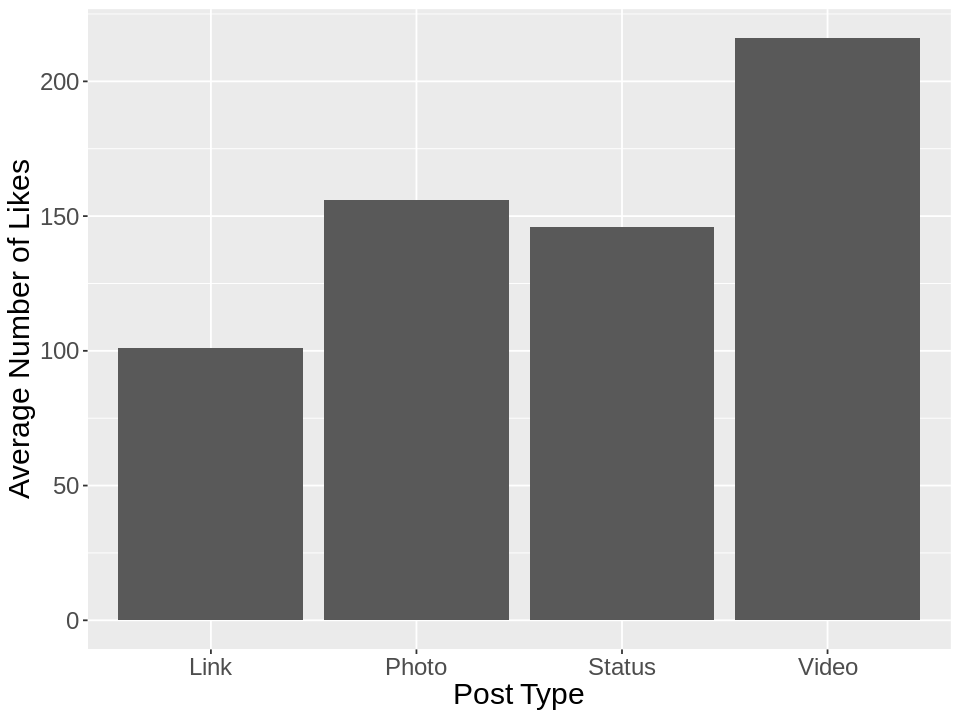

In [78]:
options(repr.plot.width = 8, repr.plot.height = 6) 

mean_likes_bar <- ggplot(filter_mean_like, aes(x = type, y = Value)) +
    geom_bar(stat = "identity") +
    labs(x = "Post Type", y = "Average Number of Likes") +
    theme(text = element_text(size = 18)) 

mean_likes_bar

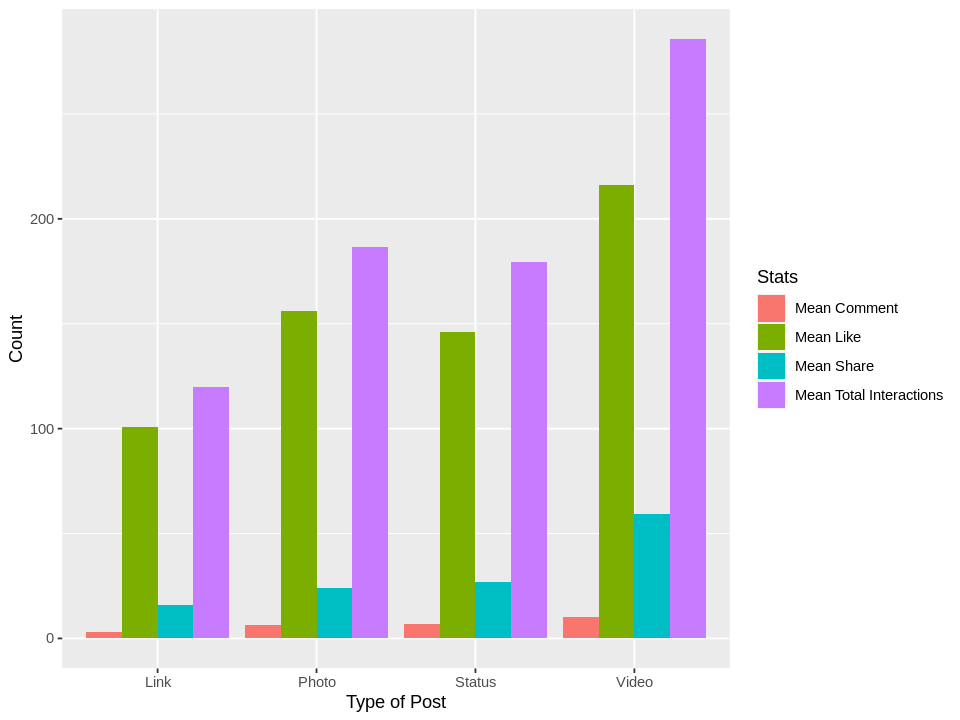

In [79]:
mean_fb <- ggplot(fb_long, aes(x = type, y = Value, fill = Stat)) +
    geom_col(position = "dodge") +
    labs(x = "Type of Post", y = "Count") +
    scale_fill_discrete(name = "Stats", labels = c("Mean Comment", "Mean Like", "Mean Share", "Mean Total Interactions"))

mean_fb

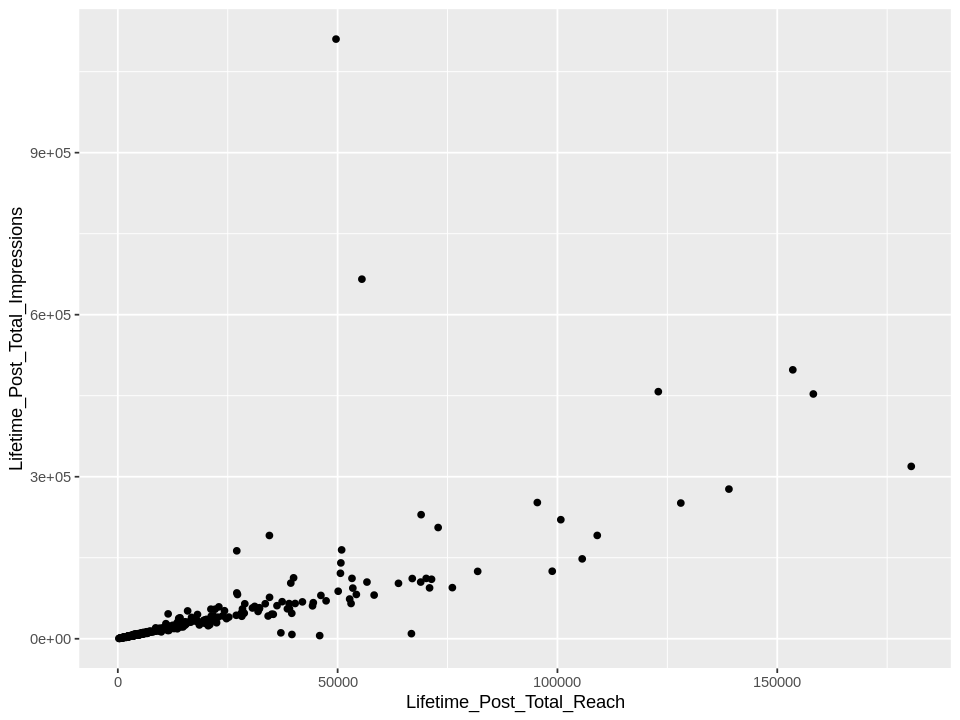

In [80]:
test_plot <- facebook %>% ggplot(aes(x = Lifetime_Post_Total_Reach, y = Lifetime_Post_Total_Impressions)) + geom_point()
test_plot

### Bibliography

Moro, S., Rita, P., & Vala, B. (2016). Predicting social media performance metrics and evaluation of the impact on brand building: A data mining approach. Journal of Business Research. 69(9), 3341 - 3351. 